# 원티드 프리온보딩 3주차 - 모두의 주차장

### 디지털 스킬셋 기술과제

주제
- 	앱 이용자 별 향후 이용 건수 예측

Value chain상 정의
- 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용

모델 개발 요건
- 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수 예측

### Data 정의

Input: Tabular 데이터
- 	2020.01.01 ~ 2020.12-31 

Output: Regression (향후 이용 건수 예측)

Task 정의
- 	Regression, 유저 별 한 달 후 이용 건수 예측

Metric 정의
- 	MSE, MAE

데이터 수집
- 유저 가입 정보: id, 가입일
- 소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수
- 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터



In [1]:
### 라이브러리 임포트
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')

Unknown system.... sorry.....


In [2]:
### 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/modu/실전db.csv')
traffic = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/modu/2020교통량통합.xlsx')
weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/modu/서울시_기상데이터.csv', encoding='cp949')
df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


In [4]:
##컬럼별 데이터 확인
len(df['USER_ID'].unique()) # USER_ID : 165425 개
type(df['JOIN_DATE'].unique()[0]) # 가입일 : str

type(df['D_TYPE'][0]) # d_type : AA, BB, CC 그룹 분류, str
len(df['STORE_ID'].unique()) ## 1061 점포 갯수
df['GOODS_TYPE'].unique() ## 상품 타입(?) A, B, C, D 그룹 분류, str
type(df['DATE'][0]) # 날짜 : str
len(df['COUNT'].unique()) ## count : 61 개
len(df['AD1'].unique()) ## 85개

# np.random.seed(42)

85

In [5]:
from datetime import datetime
df['DATE']=df['DATE'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [6]:
df.groupby('D_TYPE')['COUNT'].value_counts()

D_TYPE  COUNT
AA      1        484275
        2          7801
        3           726
        4           183
        5            83
                  ...  
CC      53            1
        55            1
        58            1
        59            1
        61            1
Name: COUNT, Length: 88, dtype: int64

In [7]:
cdf = pd.DataFrame(df.groupby('D_TYPE')['COUNT'].value_counts())
cdf.rename(columns={'COUNT':'counts_식별용'}, inplace=True)
cdf = cdf.reset_index(level = [0,1]) 
cdf

,D_TYPE,COUNT,counts_식별용
0,AA,1,484275
1,AA,2,7801
2,AA,3,726
3,AA,4,183
4,AA,5,83
...,...,...,...
83,CC,53,1
84,CC,55,1
85,CC,58,1
86,CC,59,1


In [8]:
cdf[cdf['COUNT']==cdf['COUNT'].max()]
cdf[cdf['D_TYPE']=='AA']['COUNT'].max() # 23
cdf[cdf['D_TYPE']=='AA']['COUNT'].min() # 1
cdf[cdf['D_TYPE']=='BB']['COUNT'].max() # 19
cdf[cdf['D_TYPE']=='BB']['COUNT'].min() # 1
cdf[cdf['D_TYPE']=='CC']['COUNT'].max() # 61
cdf[cdf['D_TYPE']=='CC']['COUNT'].min() # 1

1

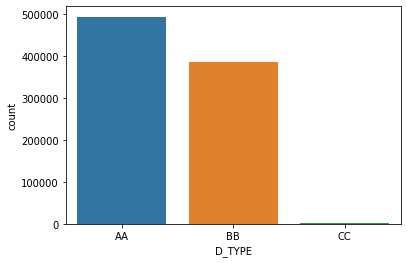

In [9]:
sns.countplot(data=df, x='D_TYPE')

### D_TYPE은 
1. AA 그룹에서 1~23
2. BB 그룹에서 1~19
3. CC 그룹에서 1~61
의 범위를 가짐

C 그룹의 결제건수가 확연히 적음

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df.groupby('AD1')['COUNT'].value_counts()
df.query('AD1 == "ZE"')['COUNT'].max()
ad = df["AD1"].tolist()
encoder.fit(ad)
ad = encoder.transform(ad)
len(list(set(ad)))


85

In [11]:
gdf = pd.DataFrame(df.groupby('GOODS_TYPE')['COUNT'].value_counts())
gdf.rename(columns={'COUNT':'counts_식별용'}, inplace=True)
gdf = gdf.reset_index(level = [0,1]) 
gdf

,GOODS_TYPE,COUNT,counts_식별용
0,A,1,599452
1,A,2,8823
2,A,3,798
3,A,4,205
4,A,5,108
...,...,...,...
113,D,11,1
114,D,15,1
115,D,23,1
116,D,26,1


In [12]:
gdf.query('GOODS_TYPE =="A"')['COUNT'].max() # 61
gdf.query('GOODS_TYPE =="A"')['COUNT'].min() # 1
gdf.query('GOODS_TYPE =="B"')['COUNT'].max() # 23
gdf.query('GOODS_TYPE =="B"')['COUNT'].min() # 1
gdf.query('GOODS_TYPE =="C"')['COUNT'].max() # 49
gdf.query('GOODS_TYPE =="C"')['COUNT'].min() # 1
gdf.query('GOODS_TYPE =="D"')['COUNT'].max() # 40
gdf.query('GOODS_TYPE =="D"')['COUNT'].min() # 1
print('A 그룹 : {},\t B 그룹 : {} \t, C 그룹 : {} \t, D 그룹 : {}  \t'.format(len(df.query('GOODS_TYPE =="A"')), len(df.query('GOODS_TYPE =="B"')), len(df.query('GOODS_TYPE =="C"')), len(df.query('GOODS_TYPE =="D"'))))

A 그룹 : 609790,	 B 그룹 : 118541 	, C 그룹 : 131163 	, D 그룹 : 19777  	


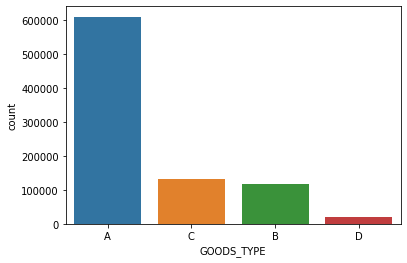

In [13]:
sns.countplot(data=df, x='GOODS_TYPE')

GOODS_TYPE은

1. A 그룹에서 1~61
2. B 그룹에서 1~23
3. C 그룹에서 1~49
4. D 그룹에서 1~40 의 범위를 가짐

A 그룹이 결제 건수가 압도적으로 높고, D 그룹의 결제 건수는 확연히 적음

In [14]:
encoder.fit(df["AD1"])
df["AD1"] = encoder.transform(df["AD1"])
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,40
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,50
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,64
3,37001,2014-12-04,BB,725,C,2020-01-01,1,53
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,52
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,40
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,19
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,52
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,50


In [15]:
encoder.fit(df["GOODS_TYPE"])
df["GOODS_TYPE"] = encoder.transform(df["GOODS_TYPE"])
encoder.fit(df["D_TYPE"])
df["D_TYPE"] = encoder.transform(df["D_TYPE"])
encoder.fit(df["DATE"])
df["date_int"] = encoder.transform(df["DATE"])
encoder.fit(df["JOIN_DATE"])
df["join_date_int"] = encoder.transform(df["JOIN_DATE"])

df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int
0,2858,2014-01-07,0,1892,0,2020-01-01,1,40,0,8
1,5647,2014-02-14,1,182009,0,2020-01-01,1,50,0,17
2,33314,2014-11-20,1,82431,0,2020-01-01,1,64,0,119
3,37001,2014-12-04,1,725,2,2020-01-01,1,53,0,133
4,37819,2014-12-07,0,220691,2,2020-01-01,1,52,0,136
...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,1,219886,1,2020-12-31,1,40,365,2351
879267,1830570,2020-12-31,1,82433,1,2020-12-31,1,19,365,2351
879268,1830580,2020-12-31,0,92020,1,2020-12-31,1,52,365,2351
879269,1830589,2020-12-31,1,92437,1,2020-12-31,1,50,365,2351


### STORE_ID별


<Figure size 1152x720 with 0 Axes>

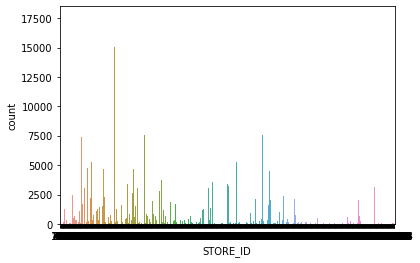

<Figure size 1152x720 with 0 Axes>

In [16]:
sns.countplot(data=df, x='STORE_ID')
plt.figure(figsize=(16,10))

In [17]:
sdf = pd.DataFrame(df.groupby('STORE_ID')['COUNT'].sum())
sdf.reset_index(level=[0], inplace=True)
sdf.sort_values('COUNT', ascending=False, inplace=True)
sdf

,STORE_ID,COUNT
514,220557,17854
612,220893,17653
533,220655,16815
142,92437,16495
603,220848,16298
...,...,...
931,230196,1
927,230190,1
464,220018,1
923,228955,1


In [18]:
slist = sdf.sort_values('COUNT', ascending=False)['STORE_ID'][:10].tolist()
clist = sdf.sort_values('COUNT', ascending=False)['COUNT'][:10].tolist()
slist
clist

[17854, 17653, 16815, 16495, 16298, 15395, 14850, 14612, 12524, 12450]

STORE_ID별 편차가 큼.

In [19]:
df.groupby('USER_ID')['COUNT'].count().max()
# df[df['USER_ID']==232]
df.query('COUNT == COUNT.max()')
df[df['USER_ID'] == 999665]
# df[df['USER_ID'] == 999665]['COUNT'].sum()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int
372,999665,2018-12-16,2,82399,0,2020-01-01,6,52,0,1605
1527,999665,2018-12-16,2,104988,0,2020-01-02,11,40,1,1605
3121,999665,2018-12-16,2,181832,0,2020-01-03,7,64,2,1605
5034,999665,2018-12-16,2,109223,0,2020-01-04,28,53,3,1605
6919,999665,2018-12-16,2,104916,0,2020-01-05,14,40,4,1605
...,...,...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,2,2428,0,2020-12-27,17,19,361,1605
868847,999665,2018-12-16,2,109267,0,2020-12-28,24,50,362,1605
871562,999665,2018-12-16,2,90193,2,2020-12-29,23,46,363,1605
874317,999665,2018-12-16,2,220797,3,2020-12-30,40,43,364,1605


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   USER_ID        879271 non-null  int64         
 1   JOIN_DATE      879271 non-null  object        
 2   D_TYPE         879271 non-null  int64         
 3   STORE_ID       879271 non-null  int64         
 4   GOODS_TYPE     879271 non-null  int64         
 5   DATE           879271 non-null  datetime64[ns]
 6   COUNT          879271 non-null  int64         
 7   AD1            879271 non-null  int64         
 8   date_int       879271 non-null  int64         
 9   join_date_int  879271 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 67.1+ MB


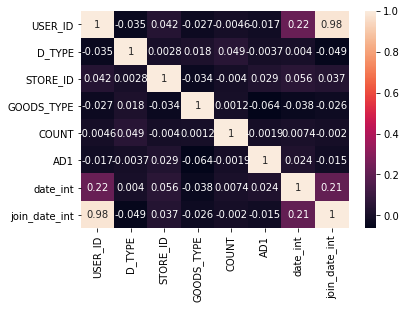

In [21]:
sns.heatmap(df.corr(), annot=True)

사실상 이 히트맵에서는 상관관계는 없다고 보는 게 맞을 듯....
유저 아이디와 회원가입일의 경우는 유저 아이디에 따라 계속해서 반복되기 때문에, 상관관계가 높은 것으로 나옴.


In [22]:
weather

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0
...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00,-11.8,NaN,4.8,54,NaN,NaN,-6.5,2.2
8756,108,2020-12-30 21:00,-12.4,NaN,3.2,58,NaN,NaN,-6.9,2.2
8757,108,2020-12-30 22:00,-12.7,NaN,2.8,56,NaN,NaN,-7.1,2.1
8758,108,2020-12-30 23:00,-12.9,NaN,2.2,54,NaN,NaN,-7.3,2.1


 ### *강수량과 적설량의 차이*

 “예보관들이 적설량을 관측할 때 쌓여있는 눈이 몇 ㎝인지 잰다”며 “하지만 눈이 내린 전체 양을 기록하기 위해서는 관측할 때 쌓여 있는 눈 외에 이미 녹은 양도 포함해 기록해야 하기 때문에 강수량인 ㎜로도 표기하는 것”

In [23]:
type(weather['일시'][0])

str

In [24]:
weather[weather['일조시간']>0]
weather.isnull().sum()
weather.fillna(0, inplace=True)
weather['is_rainy'] = weather['강수량'].apply(lambda x: 1 if x > 0 else 0) 
# weather['is_snow'] = weather['적설량'].apply(lambda x: 1 if x > 0 else 0) 
## 시간을 3시간 단위로?
# weather[weather['일시'][:10] == '2020-01-01']
# weather['일시'][0][:10]
weather['DATE']= weather['일시'].apply(lambda x : datetime.strptime(x[:10], '%Y-%m-%d'))
weather.groupby('DATE')['기온'].sum()/weather.groupby('DATE')['기온'].count()
# weather.drop('일조시간',axis=1)

DATE
2020-01-01    -2.543478
2020-01-02     0.987500
2020-01-03     0.120833
2020-01-04     1.054167
2020-01-05     1.175000
                ...    
2020-12-27     5.395833
2020-12-28     6.920833
2020-12-29     1.033333
2020-12-30   -10.366667
2020-12-31   -12.700000
Name: 기온, Length: 366, dtype: float64

### 2020 공휴일

날짜	요일	공휴일   
1월 1일	수요일	새해  
1월 24일 ~ 1월 26일	금요일 ~ 일요일	설날  
3월 1일	일요일	3·1 운동/삼일절  
4월 30일	목요일	부처님 오신 날  
5월 5일	화요일	어린이날  
6월 6일	토요일	현충일  
8월 15일	토요일	광복절  
8월 17일	월요일	광복절 휴일  
9월 30일 ~ 10월 2일	수요일 ~ 금요일	추석  
10월 3일	토요일	개천절  
10월 9일	금요일	한글날  
12월 25일	금요일	크리스마스  



In [25]:
df.sort_values('COUNT', ascending=False, inplace=True)
# df.groupby("STORE_ID")['COUNT'].value_counts()

### 날짜별 분석


In [26]:
df['day'] = [k for k in df['DATE'].dt.dayofweek] ## 요일 칼럼
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day
729776,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5
748372,999665,2018-12-16,2,109677,0,2020-11-13,59,52,317,1605,4
751974,999665,2018-12-16,2,1109,0,2020-11-14,58,52,318,1605,5
726277,999665,2018-12-16,2,190055,0,2020-11-06,55,63,310,1605,4
767392,999665,2018-12-16,2,131081,0,2020-11-19,53,82,323,1605,3
...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,0,27996,0,2020-05-27,1,50,147,2132,2
295495,1579168,2020-05-26,0,104916,0,2020-05-27,1,40,147,2132,2
295496,1579173,2020-05-26,0,93362,0,2020-05-27,1,19,147,2132,2
295497,1579174,2020-05-26,1,221017,0,2020-05-27,1,81,147,2132,2


In [27]:
df['is_weekend'] = df['day'].apply(lambda x: 1 if x > 4 else 0)
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend
729776,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1
748372,999665,2018-12-16,2,109677,0,2020-11-13,59,52,317,1605,4,0
751974,999665,2018-12-16,2,1109,0,2020-11-14,58,52,318,1605,5,1
726277,999665,2018-12-16,2,190055,0,2020-11-06,55,63,310,1605,4,0
767392,999665,2018-12-16,2,131081,0,2020-11-19,53,82,323,1605,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,0,27996,0,2020-05-27,1,50,147,2132,2,0
295495,1579168,2020-05-26,0,104916,0,2020-05-27,1,40,147,2132,2,0
295496,1579173,2020-05-26,0,93362,0,2020-05-27,1,19,147,2132,2,0
295497,1579174,2020-05-26,1,221017,0,2020-05-27,1,81,147,2132,2,0


In [28]:
h_list = ['2020-01-01', '2020-01-24', '2020-01-25','2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15','2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25']
hol_list =[]
for i in h_list:
  hol = datetime.date(datetime.strptime(i, '%Y-%m-%d'))
  print(hol)
  hol_list.append(hol)
hol_list

2020-01-01
2020-01-24
2020-01-25
2020-01-26
2020-03-01
2020-04-30
2020-05-05
2020-06-06
2020-08-15
2020-08-17
2020-09-30
2020-10-01
2020-10-02
2020-10-03
2020-10-09
2020-12-25


[datetime.date(2020, 1, 1),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 3, 1),
 datetime.date(2020, 4, 30),
 datetime.date(2020, 5, 5),
 datetime.date(2020, 6, 6),
 datetime.date(2020, 8, 15),
 datetime.date(2020, 8, 17),
 datetime.date(2020, 9, 30),
 datetime.date(2020, 10, 1),
 datetime.date(2020, 10, 2),
 datetime.date(2020, 10, 3),
 datetime.date(2020, 10, 9),
 datetime.date(2020, 12, 25)]

In [29]:
df['is_holiday'] = df['DATE'].apply(lambda x: 1 if x in hol_list else 0)

In [30]:
df.query('is_holiday == 1')['COUNT'].sum()/df.query('is_holiday == 1')['COUNT'].count()

1.0331672248999264

In [31]:
df.query('is_holiday == 0')['COUNT'].sum()/df.query('is_holiday == 0')['COUNT'].count()

1.0289615331970814

In [32]:
df.query('is_weekend == 1')['COUNT'].sum()/df.query('is_weekend == 1')['COUNT'].count()

1.033024067609774

In [33]:
df.query('is_weekend == 0')['COUNT'].sum()/df.query('is_weekend == 0')['COUNT'].count()

1.027780171143268

In [34]:
df.query('is_weekend == 0 and is_holiday == 0')['COUNT'].sum()/df.query('is_weekend == 0 and is_holiday == 0')['COUNT'].count()

1.0276775230542892

In [35]:
df.query('is_weekend == 0 and is_holiday == 1')['COUNT'].sum()/df.query('is_weekend == 0 and is_holiday == 1')['COUNT'].count()

1.0321621978602562

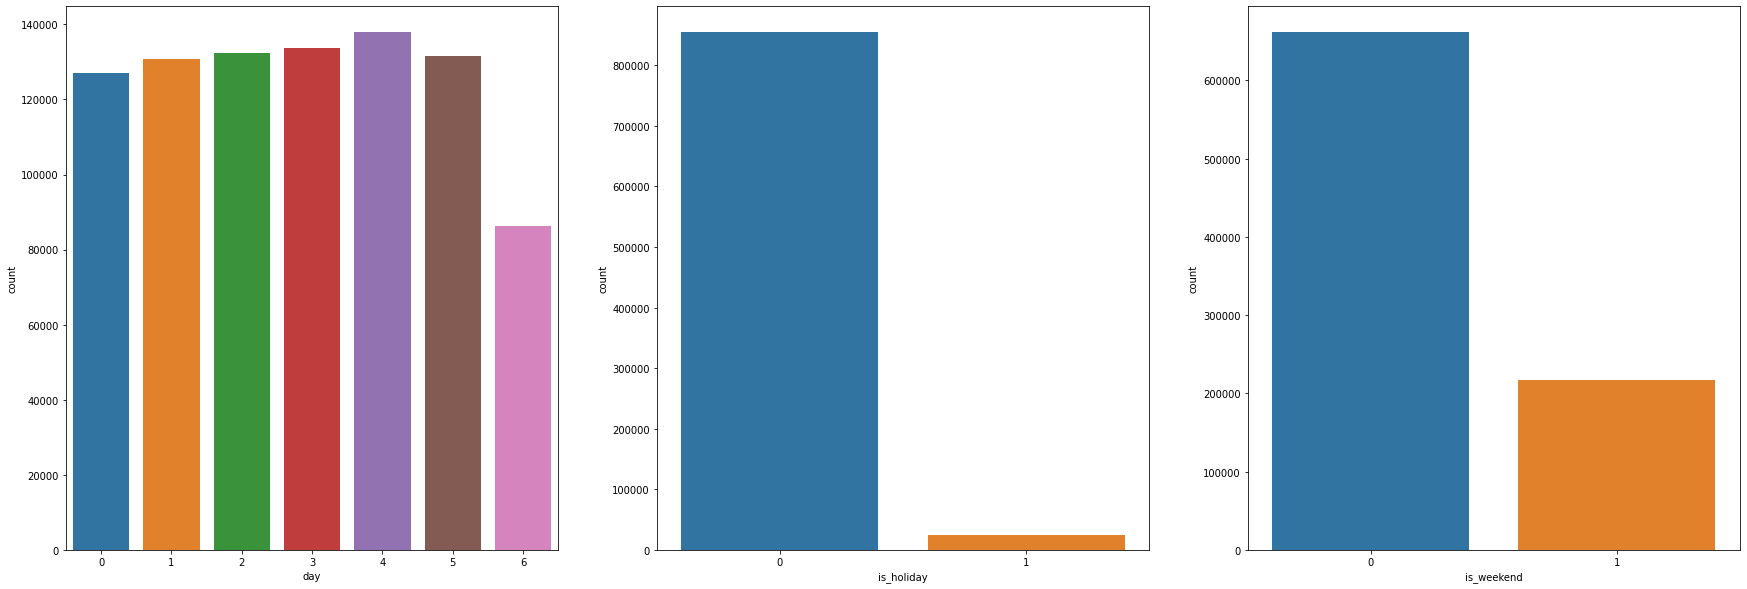

In [36]:
df.groupby('day')['COUNT'].sum()
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(30, 10)
# sns.barplot(data = df.groupby('day')['COUNT'].sum(), x = 'day')
sns.countplot(data=df, x='day', ax = ax1)
sns.countplot(data=df, x='is_holiday', ax = ax2)
sns.countplot(data=df, x='is_weekend', ax = ax3)

주말, 특히 일요일의 경우 결제 건수가 확연히 줄어드는 것을 볼 수 있고,
주말인 경우와 공휴일의 경우 절대적인 날짜의 차이가 있기때문에, 차이를 볼 수 있지만, 날짜 대비 결제 건수는 주말과 공휴일에 늘어나는 것을 볼 수 있다.


In [37]:
df['month']=df['DATE'].dt.month
df['week']=df['DATE'].dt.week
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
729776,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45
748372,999665,2018-12-16,2,109677,0,2020-11-13,59,52,317,1605,4,0,0,11,46
751974,999665,2018-12-16,2,1109,0,2020-11-14,58,52,318,1605,5,1,0,11,46
726277,999665,2018-12-16,2,190055,0,2020-11-06,55,63,310,1605,4,0,0,11,45
767392,999665,2018-12-16,2,131081,0,2020-11-19,53,82,323,1605,3,0,0,11,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,0,27996,0,2020-05-27,1,50,147,2132,2,0,0,5,22
295495,1579168,2020-05-26,0,104916,0,2020-05-27,1,40,147,2132,2,0,0,5,22
295496,1579173,2020-05-26,0,93362,0,2020-05-27,1,19,147,2132,2,0,0,5,22
295497,1579174,2020-05-26,1,221017,0,2020-05-27,1,81,147,2132,2,0,0,5,22


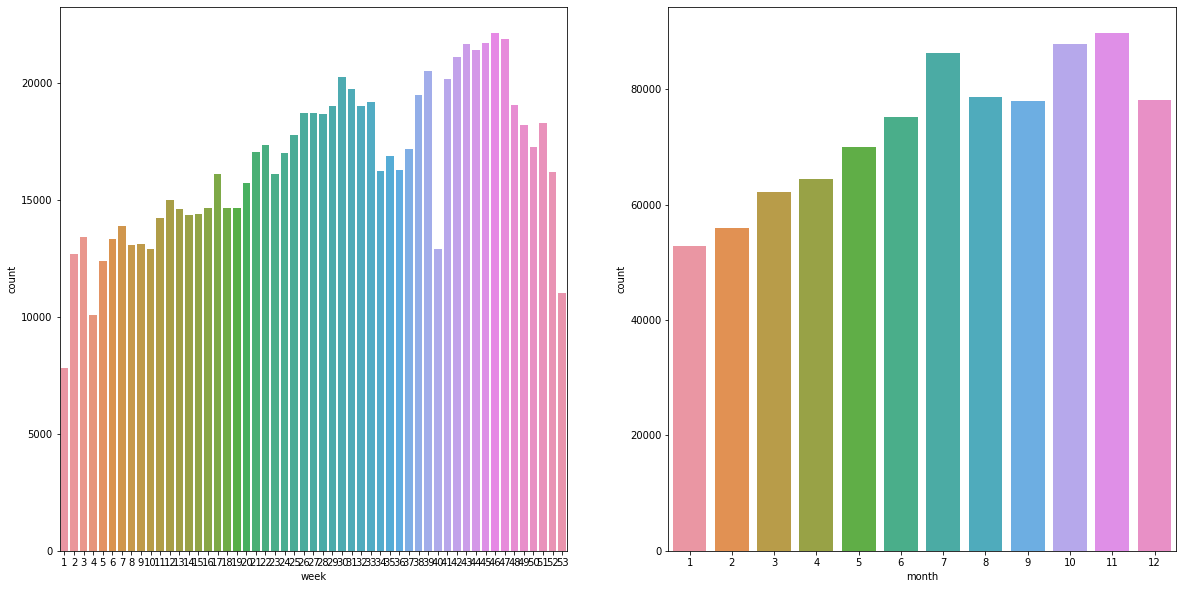

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,10)
sns.countplot(data=df, x='week', ax=ax1)
sns.countplot(data=df, x='month', ax=ax2)

In [39]:
df.query('week == 41')['COUNT'].sum() # 20816
df.query('week == 40')['COUNT'].sum() # 13329
df.query('week == 40') ## 추석이 있는 주
df.query('week == 34') ## 광복절, 대체연휴가 있는 주

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
517910,999665,2018-12-16,2,105274,2,2020-08-20,31,19,232,1605,3,0,0,8,34
515223,999665,2018-12-16,2,221018,0,2020-08-19,24,53,231,1605,2,0,0,8,34
520614,999665,2018-12-16,2,219891,0,2020-08-21,22,83,233,1605,4,0,0,8,34
512451,999665,2018-12-16,2,90193,2,2020-08-18,22,46,230,1605,1,0,0,8,34
510288,999665,2018-12-16,2,220893,0,2020-08-17,21,50,229,1605,0,0,1,8,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517311,428194,2016-12-13,0,109422,0,2020-08-20,1,50,232,872,3,0,0,8,34
517312,428836,2016-12-14,0,96266,0,2020-08-20,1,40,232,873,3,0,0,8,34
517313,429225,2016-12-14,1,109421,0,2020-08-20,1,50,232,873,3,0,0,8,34
517314,431298,2016-12-18,0,220848,1,2020-08-20,1,40,232,877,3,0,0,8,34


### 월별로 보면 주로 겨울에 비해 여름과 특히 가을에 사용량이 비교적 많은 편
### 주차별로 확인 할 경우, 연초와 연말 그리고 추석이 있는 주 차에서 이용량이 급감

---
## AD1 별

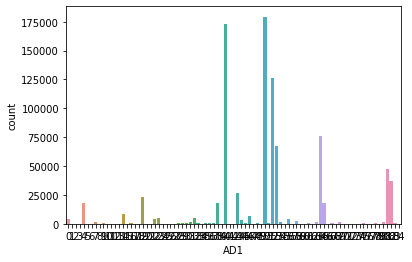

In [40]:
sns.countplot(data=df, x='AD1')

<Figure size 1152x720 with 0 Axes>

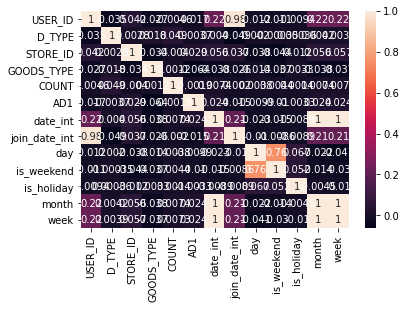

<Figure size 1152x720 with 0 Axes>

In [41]:
fig, ax = plt.subplots()
sns.heatmap(df.corr(), annot=True)
# fig.figure(figsi)
plt.figure(figsize=(16,10))

In [42]:
df.corr().query('COUNT > 0.3 or COUNT < -0.3')

,USER_ID,D_TYPE,STORE_ID,GOODS_TYPE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
COUNT,-0.004571,0.049195,-0.004013,0.001226,1.0,-0.001853,0.007376,-0.001977,0.003786,0.004417,0.00135,0.007357,0.0073


In [43]:
df.groupby('AD1')['COUNT'].value_counts()
df.groupby('AD1')['COUNT'].sum().sort_values(ascending=False)

AD1
50    184660
40    178190
52    130476
64     78176
53     69277
       ...  
71         3
72         1
55         1
2          1
42         1
Name: COUNT, Length: 85, dtype: int64

AD1 별로 결제 건수의 편차가 심함.

In [44]:
df[df["COUNT"]> 10]['USER_ID'].unique()

array([ 999665, 1635143, 1467323, 1544719, 1775410, 1675755, 1599008,
       1660735, 1675314, 1572434, 1304663, 1613793,  709657, 1407822,
       1514190,  430741])

In [45]:
## 지점은 108으로 동일
weather.drop('지점', axis=1, inplace=True)
## 풍속과는 연관이 있을까?

In [46]:
# weather['일시'][0][:10]
weather['DATE'] = weather['일시']
weather['DATE'] = weather['DATE'].apply(lambda x : datetime.strptime(x[:10], '%Y-%m-%d'))
wdf = pd.merge(df, weather, on='DATE')
wdf


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,is_rainy
0,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45,2020-11-07 0:00,14.3,0.0,1.3,78,0.0,0.0,12.1,13.1,0
1,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45,2020-11-07 1:00,14.6,0.0,2.3,83,0.0,0.0,12.4,13.1,0
2,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45,2020-11-07 2:00,14.5,0.0,1.5,84,0.0,0.0,12.4,13.1,0
3,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45,2020-11-07 3:00,14.4,0.0,1.8,87,0.0,0.0,12.3,13.1,0
4,999665,2018-12-16,2,96266,0,2020-11-07,61,40,311,1605,5,1,0,11,45,2020-11-07 4:00,14.4,0.0,2.1,89,0.0,0.0,12.4,13.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21039130,1486993,2020-02-02,1,220764,0,2020-02-18,1,19,48,2018,1,0,0,2,8,2020-02-18 19:00,-1.6,0.0,1.5,47,0.0,0.0,0.1,3.7,0
21039131,1486993,2020-02-02,1,220764,0,2020-02-18,1,19,48,2018,1,0,0,2,8,2020-02-18 20:00,-2.3,0.0,1.6,49,0.0,0.0,-0.5,3.6,0
21039132,1486993,2020-02-02,1,220764,0,2020-02-18,1,19,48,2018,1,0,0,2,8,2020-02-18 21:00,-2.7,0.0,2.0,50,0.0,0.0,-0.7,3.7,0
21039133,1486993,2020-02-02,1,220764,0,2020-02-18,1,19,48,2018,1,0,0,2,8,2020-02-18 22:00,-3.2,0.0,0.7,51,0.0,0.0,-0.9,3.7,0


In [47]:
### 날씨, 요일별 표시를 위해 평균값으로 설정.
weather_group_df = pd.DataFrame(weather.groupby('DATE').mean())
weather_group_df.reset_index(level=0, inplace=True)
# weather_group_df.drop('지점', axis=1, inplace=True)
weather_group_df.drop('풍속', axis=1, inplace=True)
weather_group_df.drop('습도', axis=1, inplace=True)
weather_group_df.drop('일조시간', axis=1, inplace=True)
weather_group_df.drop('지면온도', axis=1, inplace=True)
weather_group_df.drop('지중온도', axis=1, inplace=True)
weather_group_df

,DATE,기온,강수량,적설량,is_rainy
0,2020-01-01,-2.543478,0.004348,0.0,0.043478
1,2020-01-02,0.987500,0.000000,0.0,0.000000
2,2020-01-03,0.120833,0.000000,0.0,0.000000
3,2020-01-04,1.054167,0.000000,0.0,0.000000
4,2020-01-05,1.175000,0.000000,0.0,0.000000
...,...,...,...,...,...
361,2020-12-27,5.395833,0.000000,0.0,0.000000
362,2020-12-28,6.920833,0.054167,0.0,0.041667
363,2020-12-29,1.033333,0.008333,0.0,0.041667
364,2020-12-30,-10.366667,0.000000,0.0,0.000000


In [48]:
weather_group_df.query('적설량 > 0')

,DATE,기온,강수량,적설량,is_rainy
18,2020-01-19,1.816667,0.025000,0.012500,0.041667
34,2020-02-04,-1.416667,0.070833,0.129167,0.083333
35,2020-02-05,-7.954167,0.000000,0.291667,0.000000
46,2020-02-16,-0.570833,0.629167,1.762500,0.250000
47,2020-02-17,-5.641667,0.041667,3.187500,0.083333
48,2020-02-18,-4.275000,0.000000,1.037500,0.000000
347,2020-12-13,-0.441667,0.120833,1.520833,0.166667
348,2020-12-14,-7.450000,0.000000,1.295833,0.000000
349,2020-12-15,-8.266667,0.000000,0.929167,0.000000
350,2020-12-16,-8.200000,0.000000,0.741667,0.000000


In [49]:
weather[weather['DATE']=='2020-02-04']

,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,is_rainy,DATE
815,2020-02-04 0:00,-2.9,0.0,1.8,40,0.0,0.0,-2.0,4.2,0,2020-02-04
816,2020-02-04 1:00,-3.5,0.0,1.0,43,0.0,0.0,-2.4,4.1,0,2020-02-04
817,2020-02-04 2:00,-3.7,0.0,2.2,37,0.0,0.0,-2.7,4.0,0,2020-02-04
818,2020-02-04 3:00,-4.3,0.0,1.7,38,0.0,0.0,-3.1,4.0,0,2020-02-04
819,2020-02-04 4:00,-4.8,0.0,1.0,37,0.0,0.0,-3.5,3.9,0,2020-02-04
820,2020-02-04 5:00,-5.2,0.0,0.8,42,0.0,0.0,-4.0,3.9,0,2020-02-04
821,2020-02-04 6:00,-5.7,0.0,1.4,45,0.0,0.0,-4.2,3.8,0,2020-02-04
822,2020-02-04 7:00,-6.0,0.0,1.8,43,0.0,0.0,-4.3,3.6,0,2020-02-04
823,2020-02-04 8:00,-5.8,0.0,1.3,40,0.1,0.0,-4.0,3.6,0,2020-02-04
824,2020-02-04 9:00,-4.3,0.0,2.5,39,1.0,0.0,-2.8,3.5,0,2020-02-04


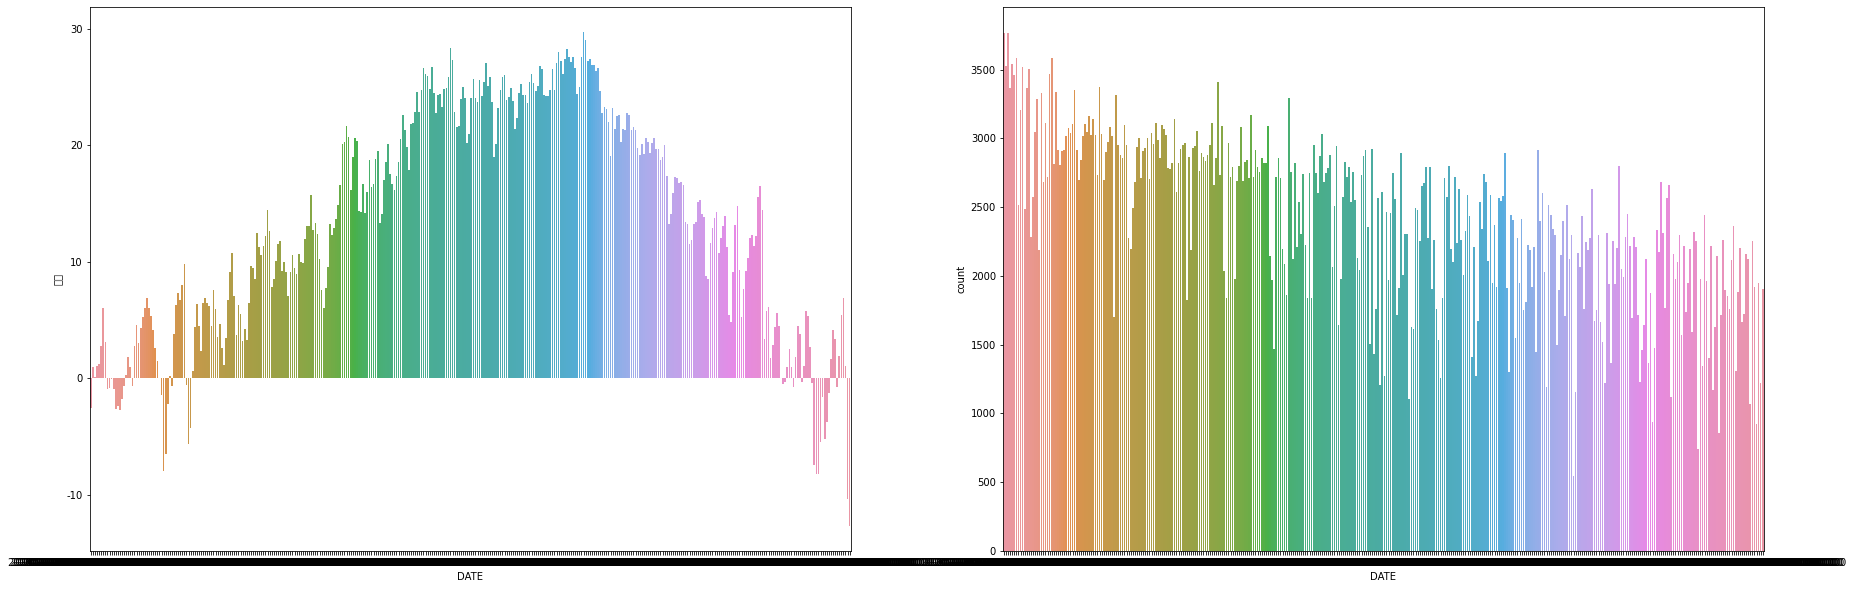

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(30,10)
sns.barplot(data=weather_group_df, x='DATE', y='기온', ax=ax1)
sns.countplot(data=df, x='DATE', ax=ax2)

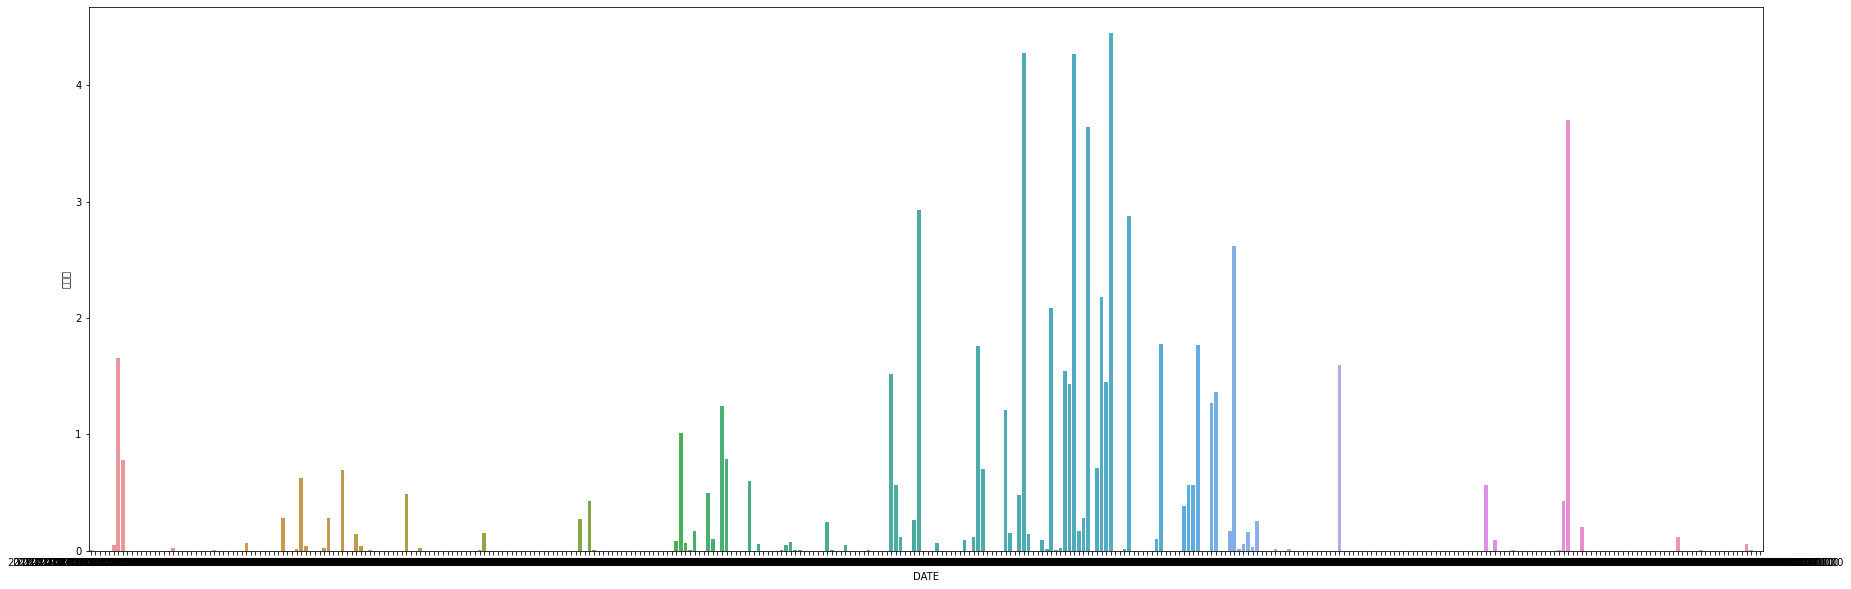

In [51]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(30,10)
sns.barplot(data=weather_group_df, x='DATE', y='강수량', ax=ax1)


In [52]:
df.COUNT.describe()
## 데이터 이상치
## 61 COUNT 
df[df['COUNT']== df['COUNT'].max()] ## 999665
df[df['USER_ID']==999665]['COUNT'].sum() ## 7919
df[df['USER_ID']==999665]['COUNT']
df.query('COUNT > 10 and USER_ID != 999665')

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
476895,1635143,2020-07-24,0,221045,0,2020-08-04,23,40,216,2191,1,0,0,8,32
419592,1467323,2020-01-11,0,220836,1,2020-07-15,23,52,196,1996,2,0,0,7,29
372116,1467323,2020-01-11,0,220836,0,2020-06-27,22,52,178,1996,5,1,0,6,26
31925,1467323,2020-01-11,0,220836,0,2020-01-18,20,52,17,1996,5,1,0,1,3
208433,1544719,2020-04-17,1,221045,0,2020-04-18,19,40,108,2093,5,1,0,4,16
757192,1775410,2020-11-14,1,92505,0,2020-11-15,17,50,319,2304,6,1,0,11,46
604384,1675755,2020-09-02,0,219913,0,2020-09-23,15,40,266,2231,2,0,0,9,39
734271,1599008,2020-06-17,1,203847,0,2020-11-08,15,64,312,2154,6,1,0,11,45
866365,1660735,2020-08-18,1,90444,0,2020-12-26,15,40,360,2216,5,1,0,12,52
618893,1675314,2020-09-01,1,109670,0,2020-09-28,15,19,271,2230,0,0,0,9,40


In [53]:
df.sort_values('COUNT', ascending=False)['USER_ID'].unique()[:10]
# df[df['USER_ID']==1775410]
df[df['COUNT']>10]["USER_ID"].unique() # 16 개
df[df['COUNT']<10]
df[df['COUNT']>10]
# df['COUNT'].describe()
## 최소 시간이 3시간 권이므로, COUNT 가 8 이상인 경우 이상치로 판단하고 드랍
ano_list = df[df['COUNT']>8]["USER_ID"].unique().tolist()
df = df[~df['USER_ID'].isin(ano_list)]
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week
806341,1790239,2020-11-25,0,1892,1,2020-12-02,8,40,336,2315,2,0,0,12,49
858031,136719,2015-08-07,1,131081,0,2020-12-23,8,82,357,378,2,0,0,12,52
738477,625145,2017-10-11,0,220661,0,2020-11-10,8,53,314,1174,1,0,0,11,46
209824,1544947,2020-04-18,0,173268,0,2020-04-19,8,50,109,2094,6,1,0,4,16
567002,1668167,2020-08-26,1,82400,0,2020-09-09,7,52,252,2224,2,0,0,9,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295494,1579165,2020-05-26,0,27996,0,2020-05-27,1,50,147,2132,2,0,0,5,22
295495,1579168,2020-05-26,0,104916,0,2020-05-27,1,40,147,2132,2,0,0,5,22
295496,1579173,2020-05-26,0,93362,0,2020-05-27,1,19,147,2132,2,0,0,5,22
295497,1579174,2020-05-26,1,221017,0,2020-05-27,1,81,147,2132,2,0,0,5,22


In [54]:
weather_group_df['is_rainy'] = weather_group_df['is_rainy'].apply(lambda x: 1 if x>0 else 0)
weather_group_df

,DATE,기온,강수량,적설량,is_rainy
0,2020-01-01,-2.543478,0.004348,0.0,1
1,2020-01-02,0.987500,0.000000,0.0,0
2,2020-01-03,0.120833,0.000000,0.0,0
3,2020-01-04,1.054167,0.000000,0.0,0
4,2020-01-05,1.175000,0.000000,0.0,0
...,...,...,...,...,...
361,2020-12-27,5.395833,0.000000,0.0,0
362,2020-12-28,6.920833,0.054167,0.0,1
363,2020-12-29,1.033333,0.008333,0.0,1
364,2020-12-30,-10.366667,0.000000,0.0,0


In [56]:
merged_df = pd.merge(df, weather_group_df, on='DATE')
merged_df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week,기온,강수량,적설량,is_rainy
0,1790239,2020-11-25,0,1892,1,2020-12-02,8,40,336,2315,2,0,0,12,49,2.516667,0.000000,0.0,0
1,1683685,2020-09-09,0,223625,0,2020-12-02,3,69,336,2238,2,0,0,12,49,2.516667,0.000000,0.0,0
2,1716723,2020-10-06,0,230991,0,2020-12-02,2,50,336,2265,2,0,0,12,49,2.516667,0.000000,0.0,0
3,324808,2016-06-25,0,28018,1,2020-12-02,2,52,336,701,2,0,0,12,49,2.516667,0.000000,0.0,0
4,1682991,2020-09-08,0,223625,0,2020-12-02,2,69,336,2237,2,0,0,12,49,2.516667,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878483,1454897,2020-01-01,0,91156,0,2020-01-01,1,64,0,1986,2,0,1,1,1,-2.543478,0.004348,0.0,1
878484,1454926,2020-01-01,0,220691,2,2020-01-01,1,52,0,1986,2,0,1,1,1,-2.543478,0.004348,0.0,1
878485,1454929,2020-01-01,1,82399,0,2020-01-01,1,52,0,1986,2,0,1,1,1,-2.543478,0.004348,0.0,1
878486,1455035,2020-01-01,0,109839,0,2020-01-01,1,40,0,1986,2,0,1,1,1,-2.543478,0.004348,0.0,1


In [59]:
merged_df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,date_int,join_date_int,day,is_weekend,is_holiday,month,week,기온,강수량,적설량,is_rainy
0,1790239,2020-11-25,0,1892,1,2020-12-02,8,40,336,2315,2,0,0,12,49,2.516667,0.000000,0.0,0
1,1683685,2020-09-09,0,223625,0,2020-12-02,3,69,336,2238,2,0,0,12,49,2.516667,0.000000,0.0,0
2,1716723,2020-10-06,0,230991,0,2020-12-02,2,50,336,2265,2,0,0,12,49,2.516667,0.000000,0.0,0
3,324808,2016-06-25,0,28018,1,2020-12-02,2,52,336,701,2,0,0,12,49,2.516667,0.000000,0.0,0
4,1682991,2020-09-08,0,223625,0,2020-12-02,2,69,336,2237,2,0,0,12,49,2.516667,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878483,1454897,2020-01-01,0,91156,0,2020-01-01,1,64,0,1986,2,0,1,1,1,-2.543478,0.004348,0.0,1
878484,1454926,2020-01-01,0,220691,2,2020-01-01,1,52,0,1986,2,0,1,1,1,-2.543478,0.004348,0.0,1
878485,1454929,2020-01-01,1,82399,0,2020-01-01,1,52,0,1986,2,0,1,1,1,-2.543478,0.004348,0.0,1
878486,1455035,2020-01-01,0,109839,0,2020-01-01,1,40,0,1986,2,0,1,1,1,-2.543478,0.004348,0.0,1


### JOIN DATE 처리 여부